# Recommendation System from the paper: An Efficient Deep Learning Approach for Collaborative Filtering Recommender System



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import os
import warnings
import tensorflow as tf
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate, Dropout
from keras.models import Model
from keras import backend as K

In [ ]:
from google.colab import files

print("Please upload your kaggle.json file.")
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Please upload your kaggle.json file.


Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 71 bytes


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! cp ./kaggle.json ~/.kaggle/
! kaggle datasets download -d aprabowo/indonesia-tourism-destination
! unzip indonesia-tourism-destination.zip

  0% 0.00/158k [00:00<?, ?B/s]
100% 158k/158k [00:00<00:00, 128MB/s]
Archive:  indonesia-tourism-destination.zip
  inflating: package_tourism.csv     
  inflating: tourism_rating.csv      
  inflating: tourism_with_id.csv     
  inflating: user.csv                


In [ ]:
tourism_df = pd.read_csv("./tourism_with_id.csv")
rating_df = pd.read_csv("./tourism_rating.csv")

In [ ]:
tourism_df.tail()

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
432,433,Museum Mpu Tantular,Museum Negeri Mpu Tantular adalah sebuah museu...,Budaya,Surabaya,2000,4.4,45.0,"{'lat': -7.4338593, 'lng': 112.7199058}",-7.433859,112.719906,NaN,433
433,434,Taman Bungkul,Taman Bungkul adalah taman wisata kota yang te...,Taman Hiburan,Surabaya,0,4.6,NaN,"{'lat': -7.291346799999999, 'lng': 112.7398218}",-7.291347,112.739822,NaN,434
434,435,Taman Air Mancur Menari Kenjeran,Air mancur menari atau dancing fountain juga a...,Taman Hiburan,Surabaya,0,4.4,45.0,"{'lat': -7.2752955, 'lng': 112.7549381}",-7.275296,112.754938,NaN,435
435,436,Taman Flora Bratang Surabaya,Taman Flora adalah salah satu taman kota di Su...,Taman Hiburan,Surabaya,0,4.6,NaN,"{'lat': -7.294330299999999, 'lng': 112.7617534}",-7.294330,112.761753,NaN,436
436,437,Gereja Perawan Maria Tak Berdosa Surabaya,Gereja Katolik Kelahiran Santa Perawan Maria m...,Tempat Ibadah,Surabaya,10000,4.8,NaN,"{'lat': -7.2420758, 'lng': 112.7368158}",-7.242076,112.736816,NaN,437


Filter the ratings, so higher ratings (4 and 5) get 1, otherwise, it gets 0.

In [ ]:
# def rating_change(rating):
#   if rating >= 4:
#     return 1
#   else:
#     return 0

preprocessing_rating_df = rating_df.copy()
# preprocessing_rating_df["Place_Ratings"] = np.vectorize(rating_change)(preprocessing_rating_df["Place_Ratings"])

In [ ]:
n_tourisms = 437
n_users = 303

print(f"Number of unique tourism places: {n_tourisms}")
print(f"Number of unique users: {n_users}")

Number of unique tourism places: 437
Number of unique users: 303


In [ ]:
# preprocessing_rating_df["Place_Ratings"]

## Data Preprocessing

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(preprocessing_rating_df, test_size=0.1, random_state=42)

print(f"Total Training Data: {len(train_df)}")
print(f"Total Testing Data: {len(test_df)}")

Total Training Data: 9000
Total Testing Data: 1000


## Data Modelling

In [ ]:
num_neurons_1 = [150, 200, 250]
activation_types = ["relu", "elu", "selu"]

def make_model(num_neurons_1, activation_type):
  # creating Movie embedding path
  tourism_input = Input(shape=[1], name="Tourism-Input")
  tourism_embedding = Embedding(n_tourisms + 1, 5, name="Tourism-Embedding")(tourism_input)

  tourism_vec = Flatten(name="Flatten-Tourism")(tourism_embedding)

  # creating user embedding path
  user_input = Input(shape=[1], name="User-Input")
  user_embedding = Embedding(n_users + 1, 5, name="User-Embedding_Tourism_input")(user_input)
  user_vec = Flatten(name="Flatten-Users_Tourism_embedding")(user_embedding)

  # concatenate features
  conc = Concatenate()([tourism_vec, user_vec])

  conc = Dropout(0.9)(conc)
  # add fully-connected-layers
  fc1 = Dense(num_neurons_1, activation = f'{activation_type}')(conc)
  fc1 = Dropout(0.8)(fc1)
  fc2 = Dense(num_neurons_1 - 50, activation = f'{activation_type}')(fc1)
  fc2 = Dropout(0.8)(fc2)
  fc3 = Dense(num_neurons_1 - 100, activation = f'{activation_type}')(fc2)
  fc3 = Dropout(0.8)(fc3)
  out = Dense(1, activation = f"{activation_type}")(fc3)

  # Create model and compile it
  model = Model([user_input, tourism_input], out)
  model.compile(keras.optimizers.Adam(learning_rate=1e-4),
                "mean_absolute_error",
                metrics = [tf.keras.metrics.RootMeanSquaredError()]
  )

  return model

In [ ]:
result_df = pd.DataFrame(
    columns = ["Neurons", "Activation", "RMSE", "MAE"]
)

class ReportCallback(tf.keras.callbacks.Callback):
  def __init__(self, neurons, activation):
    super(ReportCallback, self).__init__()
    self.neurons = neurons
    self.activation = activation
  def on_train_end(self, logs=None):
    global result_df
    print(f'Train RMSE: {logs["root_mean_squared_error"]}')
    print(f'Train MAE: {logs["loss"]}')
    print(f'Test RMSE: {logs["val_root_mean_squared_error"]}')
    print(f'Test MAE: {logs["val_loss"]}')

    result_df_new = pd.DataFrame(
      {
        "Neurons": self.neurons,
        "Activation": self.activation,
        "RMSE": [logs["val_root_mean_squared_error"]],
        "MAE": [logs["val_loss"]],
      }
    )
    result_df_2 = result_df.append(result_df_new, ignore_index = True)
    result_df = result_df_2
    print(result_df)

models = []

for num_neuron in num_neurons_1:
  for activation_type in activation_types:
    report_callback = ReportCallback(num_neuron, activation_type)

    model = make_model(num_neuron, activation_type)
    print(f"NUmber of neurons: {num_neuron}, activation type: {activation_type}")
    history = model.fit(
      [train_df["User_Id"], train_df["Place_Id"]],
      train_df["Place_Ratings"],
      validation_data = ([test_df["User_Id"], test_df["Place_Id"]], test_df["Place_Ratings"]),
      epochs = 100,
      verbose = 0,
      batch_size = 64,
      callbacks = [report_callback]
    )

    models.append(model)


NUmber of neurons: 150, activation type: relu
Train RMSE: 1.55260169506073
Train MAE: 1.3013691902160645
Test RMSE: 1.3773967027664185
Test MAE: 1.18203604221344
  Neurons Activation      RMSE       MAE
0     150       relu  1.377397  1.182036
NUmber of neurons: 150, activation type: elu


<ipython-input-14-992736324f10>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df_2 = result_df.append(result_df_new, ignore_index = True)


Train RMSE: 1.5390461683273315
Train MAE: 1.2973250150680542
Test RMSE: 1.3550968170166016
Test MAE: 1.1483596563339233
  Neurons Activation      RMSE       MAE
0     150       relu  1.377397  1.182036
1     150        elu  1.355097  1.148360


<ipython-input-14-992736324f10>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df_2 = result_df.append(result_df_new, ignore_index = True)


NUmber of neurons: 150, activation type: selu
Train RMSE: 1.5226552486419678
Train MAE: 1.2883161306381226
Test RMSE: 1.3545681238174438
Test MAE: 1.1461999416351318
  Neurons Activation      RMSE       MAE
0     150       relu  1.377397  1.182036
1     150        elu  1.355097  1.148360
2     150       selu  1.354568  1.146200


<ipython-input-14-992736324f10>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df_2 = result_df.append(result_df_new, ignore_index = True)


NUmber of neurons: 200, activation type: relu
Train RMSE: 1.504764437675476
Train MAE: 1.2712876796722412
Test RMSE: 1.3615566492080688
Test MAE: 1.1594626903533936
  Neurons Activation      RMSE       MAE
0     150       relu  1.377397  1.182036
1     150        elu  1.355097  1.148360
2     150       selu  1.354568  1.146200
3     200       relu  1.361557  1.159463
NUmber of neurons: 200, activation type: elu


<ipython-input-14-992736324f10>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df_2 = result_df.append(result_df_new, ignore_index = True)


Train RMSE: 1.4841587543487549
Train MAE: 1.2612637281417847
Test RMSE: 1.3471137285232544
Test MAE: 1.1269317865371704
  Neurons Activation      RMSE       MAE
0     150       relu  1.377397  1.182036
1     150        elu  1.355097  1.148360
2     150       selu  1.354568  1.146200
3     200       relu  1.361557  1.159463
4     200        elu  1.347114  1.126932


<ipython-input-14-992736324f10>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df_2 = result_df.append(result_df_new, ignore_index = True)


NUmber of neurons: 200, activation type: selu
Train RMSE: 1.4725192785263062
Train MAE: 1.2522852420806885
Test RMSE: 1.3456233739852905
Test MAE: 1.1229287385940552
  Neurons Activation      RMSE       MAE
0     150       relu  1.377397  1.182036
1     150        elu  1.355097  1.148360
2     150       selu  1.354568  1.146200
3     200       relu  1.361557  1.159463
4     200        elu  1.347114  1.126932
5     200       selu  1.345623  1.122929
NUmber of neurons: 250, activation type: relu


<ipython-input-14-992736324f10>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df_2 = result_df.append(result_df_new, ignore_index = True)


Train RMSE: 1.483789086341858
Train MAE: 1.2592054605484009
Test RMSE: 1.3666744232177734
Test MAE: 1.1676890850067139
  Neurons Activation      RMSE       MAE
0     150       relu  1.377397  1.182036
1     150        elu  1.355097  1.148360
2     150       selu  1.354568  1.146200
3     200       relu  1.361557  1.159463
4     200        elu  1.347114  1.126932
5     200       selu  1.345623  1.122929
6     250       relu  1.366674  1.167689


<ipython-input-14-992736324f10>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df_2 = result_df.append(result_df_new, ignore_index = True)


NUmber of neurons: 250, activation type: elu
Train RMSE: 1.465906023979187
Train MAE: 1.2481486797332764
Test RMSE: 1.3456306457519531
Test MAE: 1.1250383853912354
  Neurons Activation      RMSE       MAE
0     150       relu  1.377397  1.182036
1     150        elu  1.355097  1.148360
2     150       selu  1.354568  1.146200
3     200       relu  1.361557  1.159463
4     200        elu  1.347114  1.126932
5     200       selu  1.345623  1.122929
6     250       relu  1.366674  1.167689
7     250        elu  1.345631  1.125038
NUmber of neurons: 250, activation type: selu


<ipython-input-14-992736324f10>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df_2 = result_df.append(result_df_new, ignore_index = True)


Train RMSE: 1.4539756774902344
Train MAE: 1.2391148805618286
Test RMSE: 1.3448294401168823
Test MAE: 1.1268538236618042
  Neurons Activation      RMSE       MAE
0     150       relu  1.377397  1.182036
1     150        elu  1.355097  1.148360
2     150       selu  1.354568  1.146200
3     200       relu  1.361557  1.159463
4     200        elu  1.347114  1.126932
5     200       selu  1.345623  1.122929
6     250       relu  1.366674  1.167689
7     250        elu  1.345631  1.125038
8     250       selu  1.344829  1.126854


<ipython-input-14-992736324f10>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df_2 = result_df.append(result_df_new, ignore_index = True)


In [ ]:
print(result_df)
result_df.to_csv("efficient_deep_learning_result.csv", sep = ";", decimal = ",", index = False)

  Neurons Activation      RMSE       MAE
0     150       relu  1.377397  1.182036
1     150        elu  1.355097  1.148360
2     150       selu  1.354568  1.146200
3     200       relu  1.361557  1.159463
4     200        elu  1.347114  1.126932
5     200       selu  1.345623  1.122929
6     250       relu  1.366674  1.167689
7     250        elu  1.345631  1.125038
8     250       selu  1.344829  1.126854


In [ ]:
models[8].summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Tourism-Input (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 User-Input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Tourism-Embedding (Embedding)  (None, 1, 5)         2190        ['Tourism-Input[0][0]']          
                                                                                                  
 User-Embedding_Tourism_input (  (None, 1, 5)        1520        ['User-Input[0][0]']             
 Embedding)                                                                                

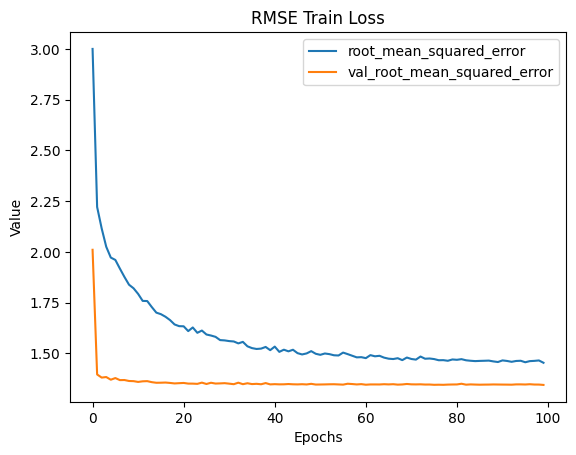

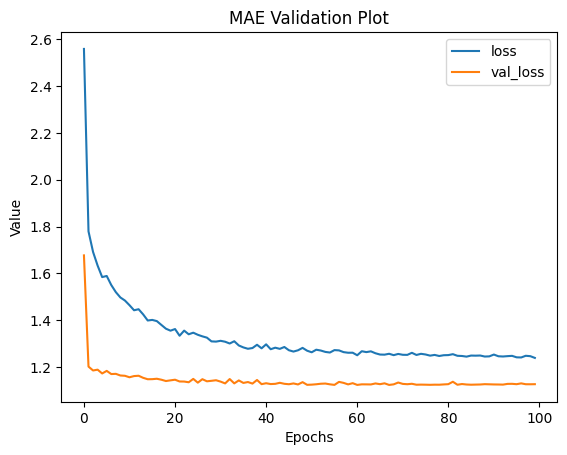

In [ ]:
def plot_data(metric1, metric2, title):
  plt.plot(history.history[metric1])
  plt.plot(history.history[metric2])
  plt.title(title)
  plt.ylabel("Value")
  plt.xlabel("Epochs")
  plt.legend([metric1, metric2], loc="upper right")
  plt.show()

metrics = [["root_mean_squared_error", "val_root_mean_squared_error", "RMSE Train Loss"], ["loss", "val_loss", "MAE Validation Plot"]]

for [metric1, metric2, title] in metrics:
  plot_data(metric1, metric2, title)

In [ ]:
tf.keras.saving.save_model(
    models[8], "drive/MyDrive/Models/best_model_efficient_deep_learning_2", overwrite=True,
)

In [ ]:
loaded_model = tf.keras.saving.load_model("drive/MyDrive/Models/best_model_efficient_deep_learning_2")
loaded_model.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Tourism-Input (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 User-Input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Tourism-Embedding (Embedding)  (None, 1, 5)         2190        ['Tourism-Input[0][0]']          
                                                                                                  
 User-Embedding_Tourism_input (  (None, 1, 5)        1520        ['User-Input[0][0]']             
 Embedding)                                                                                

In [ ]:
# Creating dataset for making recommendations for the first user
tourism_data = np.array(list(set(test_df["Place_Id"])))
tourism_data[:10]

id_user = 1
user = np.array([id_user for i in range(len(tourism_data))])
user[:10]

predictions = model.predict([user, tourism_data])

predictions = np.array([a[0] for a in predictions])

recommended_tourism_ids = (-predictions).argsort()[:10]

recommended_tourism_ids

In [ ]:
tourism_df[tourism_df["Place_Id"].isin(recommended_tourism_ids)]